In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True

In [2]:
DATA_PATH = "kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
print(DEVICE)

cuda


In [3]:
def is_all_zero(index):
    return np.all((np.array(Image.open(imagePath_df["mask-path"][index]).convert("L")).astype(np.float32) == 0))

In [4]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""

imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']

# Create an equal split of healthy and tumorous data images
healthy_df = pd.DataFrame()
tumor_df = pd.DataFrame()

for idx in range(len(imagePath_df)):
    if is_all_zero(idx):
        healthy_df = healthy_df.append(imagePath_df.loc[idx])
    else:
        tumor_df = tumor_df.append(imagePath_df.loc[idx])

train_healthy , test_healthy = train_test_split(healthy_df, test_size=0.15)
train_tumor , test_tumor = train_test_split(tumor_df, test_size=0.15)
train = shuffle(pd.concat([train_tumor, train_healthy]))
test = shuffle(pd.concat([test_tumor, test_healthy]))

In [5]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [6]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

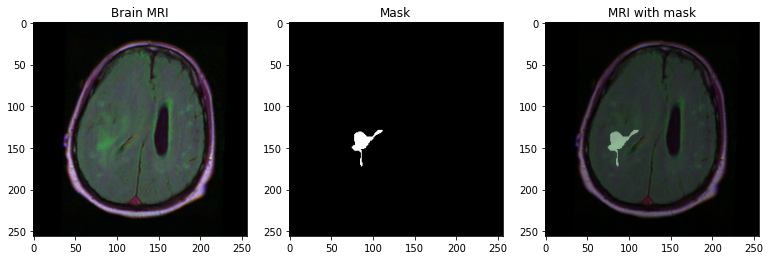

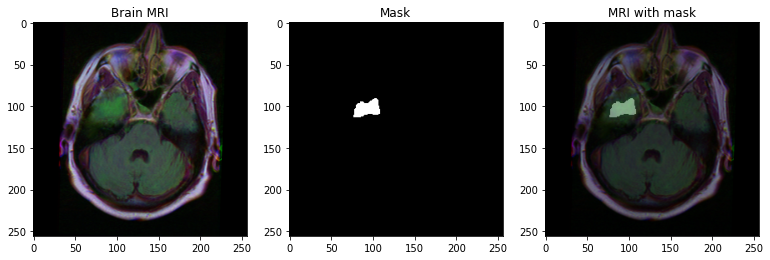

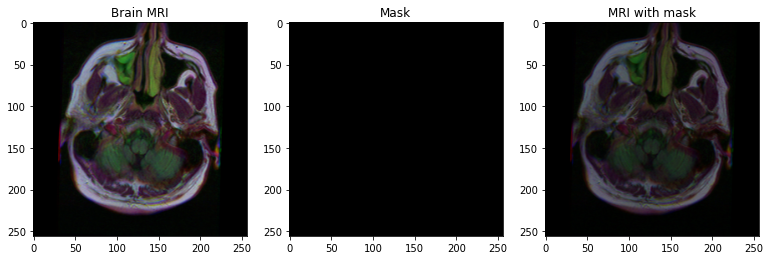

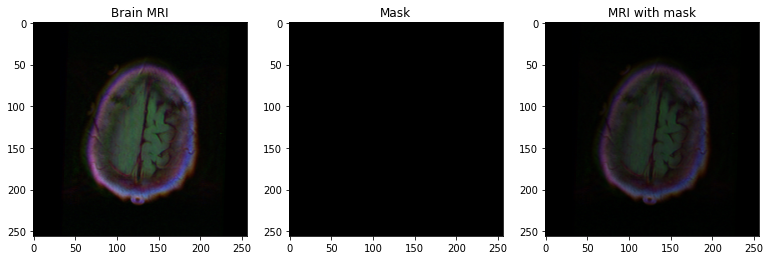

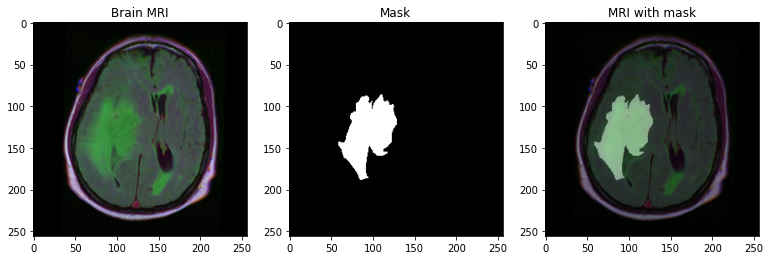

In [7]:
# Plot some example images
for i in range(5):
    plot_image(i)

In [8]:
# Training samples vs testing samples
len(train), len(test)

(3339, 590)

In [9]:
train

,directory,image-path,images,mask-path,masks
2019,TCGA_DU_5871_19941206,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_11.tif,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_11_mask.tif
263,TCGA_HT_7882_19970125,kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_1...,TCGA_HT_7882_19970125_5.tif,kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_1...,TCGA_HT_7882_19970125_5_mask.tif
1987,TCGA_HT_7881_19981015,kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_1...,TCGA_HT_7881_19981015_7.tif,kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_1...,TCGA_HT_7881_19981015_7_mask.tif
21,TCGA_DU_6404_19850629,kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,TCGA_DU_6404_19850629_38.tif,kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,TCGA_DU_6404_19850629_38_mask.tif
514,TCGA_DU_7014_19860618,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,TCGA_DU_7014_19860618_3.tif,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,TCGA_DU_7014_19860618_3_mask.tif
...,...,...,...,...,...
901,TCGA_HT_7693_19950520,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_3.tif,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_3_mask.tif
2662,TCGA_FG_7637_20000922,kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,TCGA_FG_7637_20000922_46.tif,kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,TCGA_FG_7637_20000922_46_mask.tif
1036,TCGA_CS_6665_20010817,kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_2...,TCGA_CS_6665_20010817_18.tif,kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_2...,TCGA_CS_6665_20010817_18_mask.tif
2023,TCGA_DU_5871_19941206,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_20.tif,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_20_mask.tif


In [10]:
test

,directory,image-path,images,mask-path,masks
3119,TCGA_CS_6186_20000601,kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_2...,TCGA_CS_6186_20000601_22.tif,kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_2...,TCGA_CS_6186_20000601_22_mask.tif
3651,TCGA_DU_5872_19950223,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_45.tif,kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...,TCGA_DU_5872_19950223_45_mask.tif
850,TCGA_HT_8563_19981209,kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_1...,TCGA_HT_8563_19981209_9.tif,kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_1...,TCGA_HT_8563_19981209_9_mask.tif
2676,TCGA_FG_7637_20000922,kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,TCGA_FG_7637_20000922_39.tif,kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,TCGA_FG_7637_20000922_39_mask.tif
801,TCGA_HT_7473_19970826,kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_1...,TCGA_HT_7473_19970826_11.tif,kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_1...,TCGA_HT_7473_19970826_11_mask.tif
...,...,...,...,...,...
618,TCGA_DU_8165_19970205,kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_1...,TCGA_DU_8165_19970205_10.tif,kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_1...,TCGA_DU_8165_19970205_10_mask.tif
2030,TCGA_DU_5871_19941206,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_26.tif,kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_1...,TCGA_DU_5871_19941206_26_mask.tif
3906,TCGA_DU_A5TY_19970709,kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1...,TCGA_DU_A5TY_19970709_14.tif,kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1...,TCGA_DU_A5TY_19970709_14_mask.tif
590,TCGA_FG_6689_20020326,kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_2...,TCGA_FG_6689_20020326_35.tif,kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_2...,TCGA_FG_6689_20020326_35_mask.tif


In [11]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.images = list(image_list)
        self.masks = list(mask_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))
        mask = np.array(Image.open(self.masks[index]).convert("L")).astype(np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [12]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [13]:
train_ds = BrainMRIDataset(
    image_list=list(train["image-path"]),
    mask_list=list(train["mask-path"]),
    transform=train_transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BrainMRIDataset(
    image_list=list(test["image-path"]),
    mask_list=list(test["mask-path"]),
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

Now we move on to defining the neural network, here is a basic network structure:
![UNet](UNet.png)

In [14]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [15]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # Lowest layer connecting up and down processes
        self.bottom_u = DoubleConv(features[-1], features[-1]*2)
        
        # Final convolution layer to output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_u(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [16]:
# Define unet and move to GPU
unet = UNET(in_channels = 3, out_channels = 1)
unet.to(DEVICE)
# Batch size 1, 3 color channels, 256x256 image
test_forward = unet(torch.randn((1, 3, 256, 256)).cuda())
test_forward.shape

torch.Size([1, 1, 256, 256])

In [17]:
# Define checkpoint saving

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [18]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} correct with an accuracy of {num_correct/num_pixels*100:.2f}"
    )
    score = dice_score/len(loader)
    print(f"Dice score: {score}")
    model.train()
    return score

In [19]:
def generate_predictions(
    loader, model, device="cuda"
):
    model.eval()
    predictions = []
    for x, y in loader:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float().cpu()
            predictions.append((preds, y))
    return predictions

In [20]:
def plot_image(predictions, index):
    
    fig, axs = plt.subplots(1,5, figsize=[13,15])
    
    axs[0].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(predictions[0][1][index])
    axs[1].set_title('Tumor')
    
    axs[2].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[2].imshow(predictions[0][1][index], alpha=0.4)
    axs[2].set_title('Brain with tumor')
    
    axs[4].imshow(predictions[0][0][index].permute(1, 2, 0))
    axs[4].set_title('Predicted tumor')
    
    axs[3].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[3].imshow(predictions[0][0][index].permute(1, 2, 0), alpha=0.4)
    axs[3].set_title('Brain with predicted tumor')
    
    plt.grid(False)
    plt.show()

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

In [22]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [23]:
score = 0
dice = []
learn_rate = []
worsen = 0
epochs = 0
# Train until we don't see improvement for 30 consequetive epochs
while worsen <= 30:
        train_fn(train_loader, unet, optimizer, loss_fn, scaler)

        # check accuracy
        new_score = check_accuracy(val_loader, unet, device=DEVICE)
        dice.append(new_score)
        print('Epoch {0} lr: {1}'.format(epochs+1, optimizer.param_groups[0]['lr']))
        
        if (new_score > score):
            print("Better model, saving...")
            worsen = 0
            # save model
            checkpoint = {
                "state_dict": unet.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
            score = new_score
        else:
            scheduler.step()
            print("Worse model, skipping...")
            worsen += 1
            # Reset learning rate in an attempt to escape local minima
            if worsen == 5:
                print("Spiking learning rate...")
                optimizer = optim.Adam(unet.parameters(), lr=1e-3)
                scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
            
            # Bump assist
            if worsen == 15:
                optimizer = optim.Adam(unet.parameters(), lr=1e-3)
                scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
        epochs += 1
        learn_rate.append(optimizer.param_groups[0]['lr'])

100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0889]


Got 38381618/38666240 correct with an accuracy of 99.26
Dice score: 0.4982515573501587
Epoch 1 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0469]


Got 38401403/38666240 correct with an accuracy of 99.32
Dice score: 0.5768901705741882
Epoch 2 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0412]


Got 38395389/38666240 correct with an accuracy of 99.30
Dice score: 0.6398923397064209
Epoch 3 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0161]


Got 38441500/38666240 correct with an accuracy of 99.42
Dice score: 0.6764801740646362
Epoch 4 lr: 0.001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38373867/38666240 correct with an accuracy of 99.24
Dice score: 0.6449862718582153
Epoch 5 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0232]


Got 38475403/38666240 correct with an accuracy of 99.51
Dice score: 0.7109294533729553
Epoch 6 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0275]


Got 38491569/38666240 correct with an accuracy of 99.55
Dice score: 0.7241979241371155
Epoch 7 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0158]


Got 38451194/38666240 correct with an accuracy of 99.44
Dice score: 0.7416653037071228
Epoch 8 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0196] 


Got 38480662/38666240 correct with an accuracy of 99.52
Dice score: 0.7508240938186646
Epoch 9 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00812]


Got 38508329/38666240 correct with an accuracy of 99.59
Dice score: 0.7752000093460083
Epoch 10 lr: 0.001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0125]


Got 38516777/38666240 correct with an accuracy of 99.61
Dice score: 0.7965800166130066
Epoch 11 lr: 0.001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38509877/38666240 correct with an accuracy of 99.60
Dice score: 0.7765191197395325
Epoch 12 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.0109] 


Got 38535707/38666240 correct with an accuracy of 99.66
Dice score: 0.8181664943695068
Epoch 13 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00904]


Got 38541529/38666240 correct with an accuracy of 99.68
Dice score: 0.8262943029403687
Epoch 14 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00518]


Got 38547288/38666240 correct with an accuracy of 99.69
Dice score: 0.836885929107666
Epoch 15 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00573]


Got 38548809/38666240 correct with an accuracy of 99.70
Dice score: 0.837233304977417
Epoch 16 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00589]


Got 38549509/38666240 correct with an accuracy of 99.70
Dice score: 0.8431767225265503
Epoch 17 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00643]


Got 38550609/38666240 correct with an accuracy of 99.70
Dice score: 0.8445274233818054
Epoch 18 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38552566/38666240 correct with an accuracy of 99.71
Dice score: 0.842953622341156
Epoch 19 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00514]


Got 38553210/38666240 correct with an accuracy of 99.71
Dice score: 0.851002037525177
Epoch 20 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38557201/38666240 correct with an accuracy of 99.72
Dice score: 0.8482032418251038
Epoch 21 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:24<00:00,  4.36it/s, loss=0.00925]


Got 38557747/38666240 correct with an accuracy of 99.72
Dice score: 0.8518159985542297
Epoch 22 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00646]


Got 38557369/38666240 correct with an accuracy of 99.72
Dice score: 0.8550112843513489
Epoch 23 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0081] 


Got 38558662/38666240 correct with an accuracy of 99.72
Dice score: 0.8562911152839661
Epoch 24 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0066] 


Got 38558319/38666240 correct with an accuracy of 99.72
Dice score: 0.8563168048858643
Epoch 25 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559035/38666240 correct with an accuracy of 99.72
Dice score: 0.8542546033859253
Epoch 26 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00654]


Got 38557420/38666240 correct with an accuracy of 99.72
Dice score: 0.8569557666778564
Epoch 27 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558268/38666240 correct with an accuracy of 99.72
Dice score: 0.8551487326622009
Epoch 28 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559222/38666240 correct with an accuracy of 99.72
Dice score: 0.8561587929725647
Epoch 29 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559063/38666240 correct with an accuracy of 99.72
Dice score: 0.8567456007003784
Epoch 30 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558981/38666240 correct with an accuracy of 99.72
Dice score: 0.8549838662147522
Epoch 31 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00523]


Got 38559275/38666240 correct with an accuracy of 99.72
Dice score: 0.8581644296646118
Epoch 32 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558527/38666240 correct with an accuracy of 99.72
Dice score: 0.8517003655433655
Epoch 33 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559627/38666240 correct with an accuracy of 99.72
Dice score: 0.8570547699928284
Epoch 34 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558743/38666240 correct with an accuracy of 99.72
Dice score: 0.857043445110321
Epoch 35 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559265/38666240 correct with an accuracy of 99.72
Dice score: 0.8544192314147949
Epoch 36 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558705/38666240 correct with an accuracy of 99.72
Dice score: 0.8568096160888672
Epoch 37 lr: 1.0000000000000005e-09
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38512549/38666240 correct with an accuracy of 99.60
Dice score: 0.7838394045829773
Epoch 38 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38534904/38666240 correct with an accuracy of 99.66
Dice score: 0.8038919568061829
Epoch 39 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38553402/38666240 correct with an accuracy of 99.71
Dice score: 0.842451274394989
Epoch 40 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38557983/38666240 correct with an accuracy of 99.72
Dice score: 0.8532828092575073
Epoch 41 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558430/38666240 correct with an accuracy of 99.72
Dice score: 0.8554955720901489
Epoch 42 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559002/38666240 correct with an accuracy of 99.72
Dice score: 0.8541306853294373
Epoch 43 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558813/38666240 correct with an accuracy of 99.72
Dice score: 0.8531582355499268
Epoch 44 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559301/38666240 correct with an accuracy of 99.72
Dice score: 0.8555927276611328
Epoch 45 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38559430/38666240 correct with an accuracy of 99.72
Dice score: 0.8564320802688599
Epoch 46 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38558374/38666240 correct with an accuracy of 99.72
Dice score: 0.857343852519989
Epoch 47 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38532530/38666240 correct with an accuracy of 99.65
Dice score: 0.8110054135322571
Epoch 48 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38508447/38666240 correct with an accuracy of 99.59
Dice score: 0.8077043294906616
Epoch 49 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38556731/38666240 correct with an accuracy of 99.72
Dice score: 0.8523637652397156
Epoch 50 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00702]


Got 38562969/38666240 correct with an accuracy of 99.73
Dice score: 0.8602675199508667
Epoch 51 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00613]


Got 38564815/38666240 correct with an accuracy of 99.74
Dice score: 0.8637300133705139
Epoch 52 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00538]


Got 38563492/38666240 correct with an accuracy of 99.73
Dice score: 0.8659954071044922
Epoch 53 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00572]


Got 38566085/38666240 correct with an accuracy of 99.74
Dice score: 0.8700166344642639
Epoch 54 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38563496/38666240 correct with an accuracy of 99.73
Dice score: 0.8667146563529968
Epoch 55 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00316]


Got 38569521/38666240 correct with an accuracy of 99.75
Dice score: 0.8723099231719971
Epoch 56 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00866]


Got 38569749/38666240 correct with an accuracy of 99.75
Dice score: 0.8731430768966675
Epoch 57 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570127/38666240 correct with an accuracy of 99.75
Dice score: 0.8725490570068359
Epoch 58 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570049/38666240 correct with an accuracy of 99.75
Dice score: 0.8730136752128601
Epoch 59 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00702]


Got 38569985/38666240 correct with an accuracy of 99.75
Dice score: 0.8731441497802734
Epoch 60 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38569991/38666240 correct with an accuracy of 99.75
Dice score: 0.8730908632278442
Epoch 61 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38569349/38666240 correct with an accuracy of 99.75
Dice score: 0.8726816773414612
Epoch 62 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38569251/38666240 correct with an accuracy of 99.75
Dice score: 0.8727584481239319
Epoch 63 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570436/38666240 correct with an accuracy of 99.75
Dice score: 0.8717840313911438
Epoch 64 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568576/38666240 correct with an accuracy of 99.75
Dice score: 0.8700542449951172
Epoch 65 lr: 1.0000000000000004e-08
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38527951/38666240 correct with an accuracy of 99.64
Dice score: 0.7903552651405334
Epoch 66 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38531561/38666240 correct with an accuracy of 99.65
Dice score: 0.8053213953971863
Epoch 67 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568603/38666240 correct with an accuracy of 99.75
Dice score: 0.8694018125534058
Epoch 68 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38568275/38666240 correct with an accuracy of 99.75
Dice score: 0.8640334606170654
Epoch 69 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570864/38666240 correct with an accuracy of 99.75
Dice score: 0.8714389801025391
Epoch 70 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.0023] 


Got 38571649/38666240 correct with an accuracy of 99.76
Dice score: 0.874126136302948
Epoch 71 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38572161/38666240 correct with an accuracy of 99.76
Dice score: 0.8740363717079163
Epoch 72 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38571650/38666240 correct with an accuracy of 99.76
Dice score: 0.8737587332725525
Epoch 73 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38571116/38666240 correct with an accuracy of 99.75
Dice score: 0.8723394274711609
Epoch 74 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.41it/s, loss=0.00413]


Got 38570765/38666240 correct with an accuracy of 99.75
Dice score: 0.8748255372047424
Epoch 75 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38571247/38666240 correct with an accuracy of 99.75
Dice score: 0.8743506073951721
Epoch 76 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570270/38666240 correct with an accuracy of 99.75
Dice score: 0.874312162399292
Epoch 77 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570252/38666240 correct with an accuracy of 99.75
Dice score: 0.8742172718048096
Epoch 78 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38569759/38666240 correct with an accuracy of 99.75
Dice score: 0.8741483092308044
Epoch 79 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38570935/38666240 correct with an accuracy of 99.75
Dice score: 0.8737311959266663
Epoch 80 lr: 1.0000000000000005e-09
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38546766/38666240 correct with an accuracy of 99.69
Dice score: 0.8404994010925293
Epoch 81 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38519793/38666240 correct with an accuracy of 99.62
Dice score: 0.8258498311042786
Epoch 82 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00183]


Got 38573462/38666240 correct with an accuracy of 99.76
Dice score: 0.8768633604049683
Epoch 83 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38574873/38666240 correct with an accuracy of 99.76
Dice score: 0.876531183719635
Epoch 84 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.0066] 


Got 38576885/38666240 correct with an accuracy of 99.77
Dice score: 0.8809365034103394
Epoch 85 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0121] 


Got 38576841/38666240 correct with an accuracy of 99.77
Dice score: 0.8834820985794067
Epoch 86 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38577235/38666240 correct with an accuracy of 99.77
Dice score: 0.8830404877662659
Epoch 87 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00795]


Got 38578707/38666240 correct with an accuracy of 99.77
Dice score: 0.8845449090003967
Epoch 88 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00393]


Got 38578929/38666240 correct with an accuracy of 99.77
Dice score: 0.8855297565460205
Epoch 89 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38579047/38666240 correct with an accuracy of 99.77
Dice score: 0.8847161531448364
Epoch 90 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38579925/38666240 correct with an accuracy of 99.78
Dice score: 0.8845848441123962
Epoch 91 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578053/38666240 correct with an accuracy of 99.77
Dice score: 0.8849277496337891
Epoch 92 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578698/38666240 correct with an accuracy of 99.77
Dice score: 0.8851319551467896
Epoch 93 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580018/38666240 correct with an accuracy of 99.78
Dice score: 0.8849661946296692
Epoch 94 lr: 1.0000000000000002e-07
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38528877/38666240 correct with an accuracy of 99.64
Dice score: 0.8293178677558899
Epoch 95 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38564857/38666240 correct with an accuracy of 99.74
Dice score: 0.8610260486602783
Epoch 96 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578062/38666240 correct with an accuracy of 99.77
Dice score: 0.8830457925796509
Epoch 97 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580146/38666240 correct with an accuracy of 99.78
Dice score: 0.8855077624320984
Epoch 98 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580916/38666240 correct with an accuracy of 99.78
Dice score: 0.8854420185089111
Epoch 99 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00454]


Got 38580417/38666240 correct with an accuracy of 99.78
Dice score: 0.886945903301239
Epoch 100 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580593/38666240 correct with an accuracy of 99.78
Dice score: 0.8867414593696594
Epoch 101 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00904]


Got 38580459/38666240 correct with an accuracy of 99.78
Dice score: 0.8871100544929504
Epoch 102 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00604]


Got 38580790/38666240 correct with an accuracy of 99.78
Dice score: 0.8871404528617859
Epoch 103 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0023] 


Got 38580271/38666240 correct with an accuracy of 99.78
Dice score: 0.8872376680374146
Epoch 104 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.00495]


Got 38580775/38666240 correct with an accuracy of 99.78
Dice score: 0.8873993754386902
Epoch 105 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38581286/38666240 correct with an accuracy of 99.78
Dice score: 0.8873107433319092
Epoch 106 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580768/38666240 correct with an accuracy of 99.78
Dice score: 0.886793315410614
Epoch 107 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38581182/38666240 correct with an accuracy of 99.78
Dice score: 0.8864086866378784
Epoch 108 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00392]


Got 38580360/38666240 correct with an accuracy of 99.78
Dice score: 0.887520968914032
Epoch 109 lr: 1.0000000000000002e-07
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38581286/38666240 correct with an accuracy of 99.78
Dice score: 0.8869650959968567
Epoch 110 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580955/38666240 correct with an accuracy of 99.78
Dice score: 0.8871578574180603
Epoch 111 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38581322/38666240 correct with an accuracy of 99.78
Dice score: 0.8867257833480835
Epoch 112 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580932/38666240 correct with an accuracy of 99.78
Dice score: 0.8873913288116455
Epoch 113 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38580657/38666240 correct with an accuracy of 99.78
Dice score: 0.8870260119438171
Epoch 114 lr: 1.0000000000000005e-09
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38569973/38666240 correct with an accuracy of 99.75
Dice score: 0.8691640496253967
Epoch 115 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38562317/38666240 correct with an accuracy of 99.73
Dice score: 0.8589120507240295
Epoch 116 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38582474/38666240 correct with an accuracy of 99.78
Dice score: 0.8870338797569275
Epoch 117 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00405]


Got 38582919/38666240 correct with an accuracy of 99.78
Dice score: 0.8899442553520203
Epoch 118 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.00778]


Got 38585051/38666240 correct with an accuracy of 99.79
Dice score: 0.891178548336029
Epoch 119 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00474]


Got 38585375/38666240 correct with an accuracy of 99.79
Dice score: 0.8941181898117065
Epoch 120 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.36it/s, loss=0.00246]


Got 38586596/38666240 correct with an accuracy of 99.79
Dice score: 0.8943638205528259
Epoch 121 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.0015] 


Got 38587297/38666240 correct with an accuracy of 99.80
Dice score: 0.8950867056846619
Epoch 122 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.0054] 


Got 38587402/38666240 correct with an accuracy of 99.80
Dice score: 0.8972743153572083
Epoch 123 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588163/38666240 correct with an accuracy of 99.80
Dice score: 0.8963653445243835
Epoch 124 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00663]


Got 38589064/38666240 correct with an accuracy of 99.80
Dice score: 0.8975833058357239
Epoch 125 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589102/38666240 correct with an accuracy of 99.80
Dice score: 0.8972799181938171
Epoch 126 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00125]


Got 38589383/38666240 correct with an accuracy of 99.80
Dice score: 0.8982410430908203
Epoch 127 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589018/38666240 correct with an accuracy of 99.80
Dice score: 0.8982407450675964
Epoch 128 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589064/38666240 correct with an accuracy of 99.80
Dice score: 0.8978578448295593
Epoch 129 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00727]


Got 38589502/38666240 correct with an accuracy of 99.80
Dice score: 0.8984414935112
Epoch 130 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589244/38666240 correct with an accuracy of 99.80
Dice score: 0.897964358329773
Epoch 131 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589424/38666240 correct with an accuracy of 99.80
Dice score: 0.8982282280921936
Epoch 132 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589494/38666240 correct with an accuracy of 99.80
Dice score: 0.8975774645805359
Epoch 133 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589727/38666240 correct with an accuracy of 99.80
Dice score: 0.8982812762260437
Epoch 134 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589595/38666240 correct with an accuracy of 99.80
Dice score: 0.8977974653244019
Epoch 135 lr: 1.0000000000000004e-08
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38567276/38666240 correct with an accuracy of 99.74
Dice score: 0.8647563457489014
Epoch 136 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38564838/38666240 correct with an accuracy of 99.74
Dice score: 0.8696147799491882
Epoch 137 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38585719/38666240 correct with an accuracy of 99.79
Dice score: 0.892431378364563
Epoch 138 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38587870/38666240 correct with an accuracy of 99.80
Dice score: 0.8937392830848694
Epoch 139 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588495/38666240 correct with an accuracy of 99.80
Dice score: 0.8972935080528259
Epoch 140 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589322/38666240 correct with an accuracy of 99.80
Dice score: 0.8978029489517212
Epoch 141 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588982/38666240 correct with an accuracy of 99.80
Dice score: 0.897718608379364
Epoch 142 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588863/38666240 correct with an accuracy of 99.80
Dice score: 0.8977550864219666
Epoch 143 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588807/38666240 correct with an accuracy of 99.80
Dice score: 0.8980193138122559
Epoch 144 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38589166/38666240 correct with an accuracy of 99.80
Dice score: 0.8980517983436584
Epoch 145 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38553534/38666240 correct with an accuracy of 99.71
Dice score: 0.855522871017456
Epoch 146 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38583416/38666240 correct with an accuracy of 99.79
Dice score: 0.8856231570243835
Epoch 147 lr: 0.001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00237]


Got 38591365/38666240 correct with an accuracy of 99.81
Dice score: 0.9004313945770264
Epoch 148 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.00105]


Got 38591870/38666240 correct with an accuracy of 99.81
Dice score: 0.9015015363693237
Epoch 149 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00429]


Got 38592843/38666240 correct with an accuracy of 99.81
Dice score: 0.9021585583686829
Epoch 150 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.40it/s, loss=0.00111]


Got 38592009/38666240 correct with an accuracy of 99.81
Dice score: 0.9022113680839539
Epoch 151 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00302]


Got 38593607/38666240 correct with an accuracy of 99.81
Dice score: 0.9035630822181702
Epoch 152 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00294]


Got 38593596/38666240 correct with an accuracy of 99.81
Dice score: 0.9036256670951843
Epoch 153 lr: 0.0001
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.00232]


Got 38594665/38666240 correct with an accuracy of 99.81
Dice score: 0.9047688841819763
Epoch 154 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592827/38666240 correct with an accuracy of 99.81
Dice score: 0.903022050857544
Epoch 155 lr: 0.0001
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.000873]


Got 38594437/38666240 correct with an accuracy of 99.81
Dice score: 0.9050619006156921
Epoch 156 lr: 0.0001
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594443/38666240 correct with an accuracy of 99.81
Dice score: 0.9042422771453857
Epoch 157 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595226/38666240 correct with an accuracy of 99.82
Dice score: 0.9049993753433228
Epoch 158 lr: 1e-05
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00992]


Got 38595424/38666240 correct with an accuracy of 99.82
Dice score: 0.9051662087440491
Epoch 159 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00434]


Got 38595647/38666240 correct with an accuracy of 99.82
Dice score: 0.9054629802703857
Epoch 160 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.0043] 


Got 38595918/38666240 correct with an accuracy of 99.82
Dice score: 0.9057286977767944
Epoch 161 lr: 1e-05
Better model, saving...
=> Saving checkpoint


100%|██████████| 105/105 [00:24<00:00,  4.35it/s, loss=0.00463]


Got 38595585/38666240 correct with an accuracy of 99.82
Dice score: 0.9057552218437195
Epoch 162 lr: 1e-05
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595657/38666240 correct with an accuracy of 99.82
Dice score: 0.9054121971130371
Epoch 163 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595670/38666240 correct with an accuracy of 99.82
Dice score: 0.9056776165962219
Epoch 164 lr: 1.0000000000000002e-06
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00327]


Got 38595939/38666240 correct with an accuracy of 99.82
Dice score: 0.9059205651283264
Epoch 165 lr: 1.0000000000000002e-06
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38596247/38666240 correct with an accuracy of 99.82
Dice score: 0.9057947397232056
Epoch 166 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595886/38666240 correct with an accuracy of 99.82
Dice score: 0.9053089618682861
Epoch 167 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38596187/38666240 correct with an accuracy of 99.82
Dice score: 0.9059126973152161
Epoch 168 lr: 1.0000000000000002e-07
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.39it/s, loss=0.00673]


Got 38596253/38666240 correct with an accuracy of 99.82
Dice score: 0.9060412049293518
Epoch 169 lr: 1.0000000000000004e-08
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595433/38666240 correct with an accuracy of 99.82
Dice score: 0.9054927825927734
Epoch 170 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595777/38666240 correct with an accuracy of 99.82
Dice score: 0.9056230783462524
Epoch 171 lr: 1.0000000000000004e-08
Worse model, skipping...


100%|██████████| 105/105 [00:24<00:00,  4.37it/s, loss=0.0055] 


Got 38596185/38666240 correct with an accuracy of 99.82
Dice score: 0.9061113595962524
Epoch 172 lr: 1.0000000000000005e-09
Better model, saving...
=> Saving checkpoint


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595835/38666240 correct with an accuracy of 99.82
Dice score: 0.9056195616722107
Epoch 173 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595515/38666240 correct with an accuracy of 99.82
Dice score: 0.9055196642875671
Epoch 174 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595774/38666240 correct with an accuracy of 99.82
Dice score: 0.9056841135025024
Epoch 175 lr: 1.0000000000000006e-10
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595867/38666240 correct with an accuracy of 99.82
Dice score: 0.9057629108428955
Epoch 176 lr: 1.0000000000000006e-10
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595640/38666240 correct with an accuracy of 99.82
Dice score: 0.9056868553161621
Epoch 177 lr: 1.0000000000000006e-11
Worse model, skipping...
Spiking learning rate...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38588391/38666240 correct with an accuracy of 99.80
Dice score: 0.8979970216751099
Epoch 178 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38583699/38666240 correct with an accuracy of 99.79
Dice score: 0.8862078785896301
Epoch 179 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592872/38666240 correct with an accuracy of 99.81
Dice score: 0.9025726318359375
Epoch 180 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595131/38666240 correct with an accuracy of 99.82
Dice score: 0.9054707288742065
Epoch 181 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594763/38666240 correct with an accuracy of 99.82
Dice score: 0.9049952626228333
Epoch 182 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38595133/38666240 correct with an accuracy of 99.82
Dice score: 0.9053213000297546
Epoch 183 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594527/38666240 correct with an accuracy of 99.81
Dice score: 0.9050211906433105
Epoch 184 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594813/38666240 correct with an accuracy of 99.82
Dice score: 0.9048947691917419
Epoch 185 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594517/38666240 correct with an accuracy of 99.81
Dice score: 0.9048234820365906
Epoch 186 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38594750/38666240 correct with an accuracy of 99.82
Dice score: 0.9048552513122559
Epoch 187 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38578857/38666240 correct with an accuracy of 99.77
Dice score: 0.87957763671875
Epoch 188 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38582705/38666240 correct with an accuracy of 99.78
Dice score: 0.8892554044723511
Epoch 189 lr: 0.001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38590967/38666240 correct with an accuracy of 99.81
Dice score: 0.8987024426460266
Epoch 190 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592798/38666240 correct with an accuracy of 99.81
Dice score: 0.9002581238746643
Epoch 191 lr: 0.0001
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593051/38666240 correct with an accuracy of 99.81
Dice score: 0.9014280438423157
Epoch 192 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592999/38666240 correct with an accuracy of 99.81
Dice score: 0.9020100831985474
Epoch 193 lr: 1e-05
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593446/38666240 correct with an accuracy of 99.81
Dice score: 0.9012516736984253
Epoch 194 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593347/38666240 correct with an accuracy of 99.81
Dice score: 0.9013627767562866
Epoch 195 lr: 1.0000000000000002e-06
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592863/38666240 correct with an accuracy of 99.81
Dice score: 0.9014946818351746
Epoch 196 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593315/38666240 correct with an accuracy of 99.81
Dice score: 0.9011566638946533
Epoch 197 lr: 1.0000000000000002e-07
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593328/38666240 correct with an accuracy of 99.81
Dice score: 0.901310384273529
Epoch 198 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592405/38666240 correct with an accuracy of 99.81
Dice score: 0.9016722440719604
Epoch 199 lr: 1.0000000000000004e-08
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592980/38666240 correct with an accuracy of 99.81
Dice score: 0.9013130068778992
Epoch 200 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38593112/38666240 correct with an accuracy of 99.81
Dice score: 0.9012967944145203
Epoch 201 lr: 1.0000000000000005e-09
Worse model, skipping...


  0%|          | 0/105 [00:00<?, ?it/s]

Got 38592704/38666240 correct with an accuracy of 99.81
Dice score: 0.9016610383987427
Epoch 202 lr: 1.0000000000000006e-10
Worse model, skipping...


100%|██████████| 105/105 [00:23<00:00,  4.38it/s, loss=0.00995]


Got 38593354/38666240 correct with an accuracy of 99.81
Dice score: 0.9011048674583435
Epoch 203 lr: 1.0000000000000006e-10
Worse model, skipping...


In [24]:
# Load best model

load_checkpoint(torch.load("checkpoint.pth.tar"), unet)

=> Loading checkpoint


In [25]:
predictions = generate_predictions(val_loader, unet, "cuda")

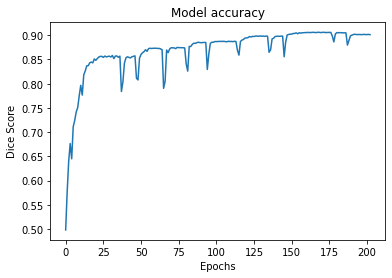

Got 38596185/38666240 correct with an accuracy of 99.82
Dice score: 0.9061113595962524


tensor(0.9061, device='cuda:0')

In [26]:
cpu_accuracy = [elem.cpu() for elem in dice]
x = np.arange(0, len(dice))
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.plot(x, cpu_accuracy)
plt.show()
check_accuracy(val_loader, unet, device=DEVICE)

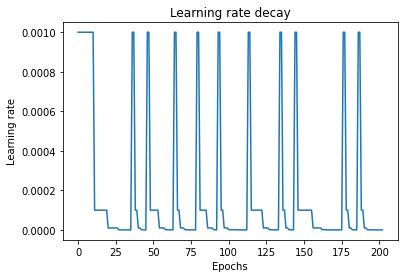

In [27]:
x = np.arange(0, len(learn_rate))
plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(x, learn_rate)
plt.show()

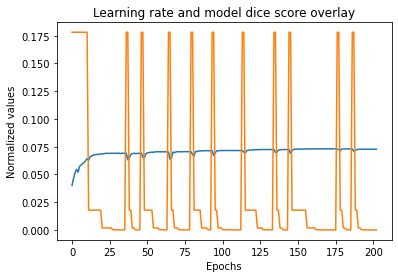

In [33]:
cpu_norm = cpu_accuracy / np.linalg.norm(cpu_accuracy)
learn_norm = learn_rate / np.linalg.norm(learn_rate)
plt.plot(x, cpu_norm)
plt.plot(x, learn_norm)
plt.xlabel("Epochs")
plt.ylabel("Normalized values")
plt.title("Learning rate and model dice score overlay")
plt.show()

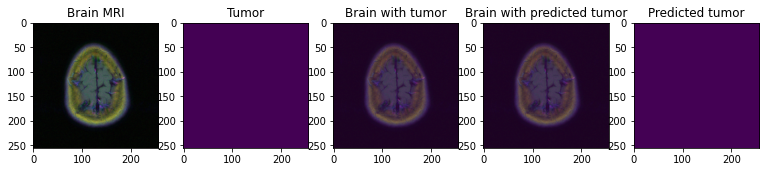

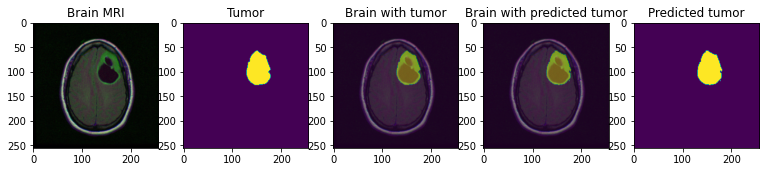

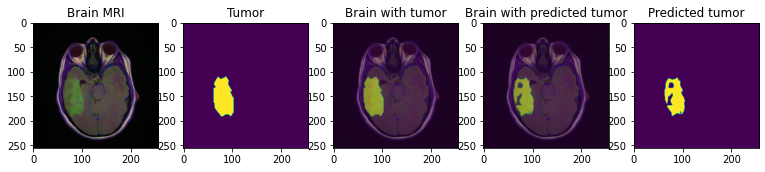

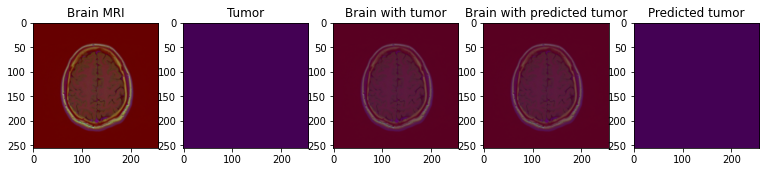

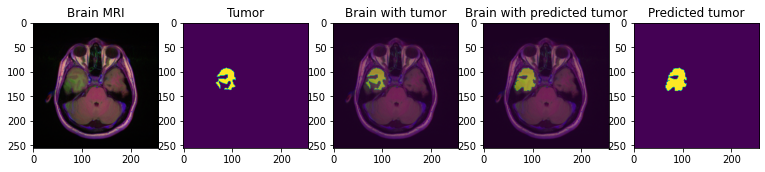

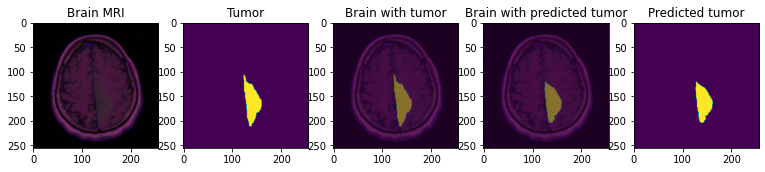

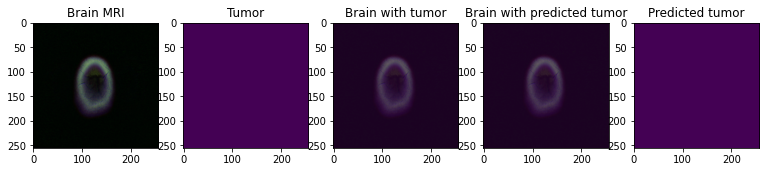

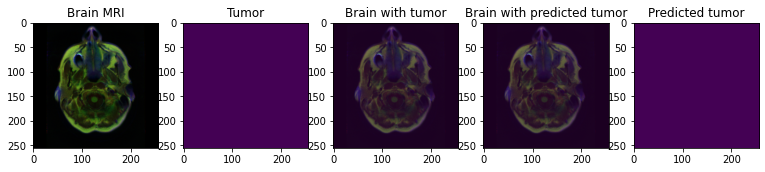

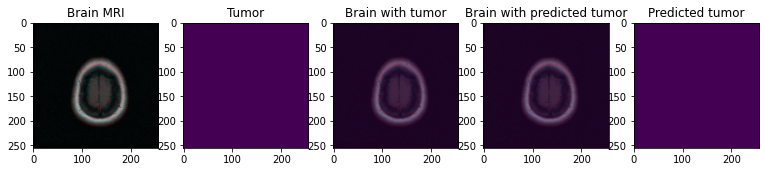

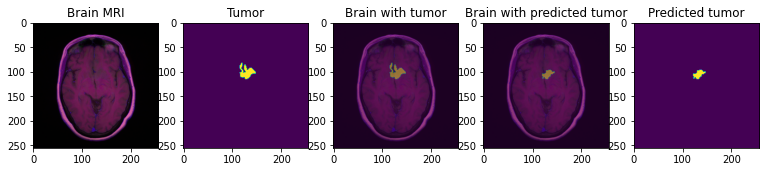

In [28]:
for i in range(10):
    plot_image(predictions, i)

In [29]:
check_accuracy(val_loader, unet, device=DEVICE)

Got 38596185/38666240 correct with an accuracy of 99.82
Dice score: 0.9061113595962524


tensor(0.9061, device='cuda:0')